<a href="https://colab.research.google.com/github/kyjhub/OSS_project/blob/main/naver_all_movie_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [1]:
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import quote
import requests
import pandas as pd
from urllib.parse import quote
from urllib.error import HTTPError, URLError
import cv2 
from google.colab.patches import cv2_imshow
import re
import numpy as np

# 영화제목 입력

In [2]:
movie_name_ = input('어떤 영화를 검색하시겠습니까 : ')
movie_name = quote(movie_name_)

어떤 영화를 검색하시겠습니까 : 엔시티 드림


In [3]:
url = 'https://movie.naver.com/movie/search/result.naver?query=' + movie_name + '&section=all&ie=utf8'

## 입력값에 대한 영화 목록
- 영화 제목을 완벽하게 알지 못할 때 기억나는 단어만 입력하면  
영화 제목에 입력 문자열이 있는 영화 정보와 포스터 출력

In [4]:
movie_page = requests.get(url).content
movie_page_soup = BeautifulSoup(movie_page, 'html.parser')
#더 많은 영화보기 버튼 url 추출
more_exist = False
more_button = movie_page_soup.find('div', {'class' : 'search_all'}).find('a', {'class' : 'more_list'})
if more_button.get_text() == '더 많은 영화 보기':
  more_exist = True
  url = 'http://movie.naver.com/movie/search/result.naver?section=movie&query=' + movie_name
  #more_url = re.findall(r'\/[\w\W]+\"', str(more_button))
  #more_url = more_url[0][:-1]

===================1번째 영화==================
엔시티 드림 더 무비 : 인 어 드림 (NCT DREAM THE MOVIE : In A DREAM)

9.05 (참여 83명)

다큐멘터리| 대한민국|117분 |2022
감독 : 이예지, 오윤동|출연 : 마크, 런쥔, 제노, 해찬, 재민, 천러, 지성


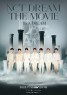

In [5]:
num=1
movie_codes = []
while True:
  movie_page = requests.get(url).content
  movie_page_soup = BeautifulSoup(movie_page, 'html.parser')
  movie_lists = movie_page_soup.find('ul', {'class' : 'search_list_1'}).find_all('li')
  for movie in movie_lists:
    try:
      movie_img_url = movie.find('img').get('src')
      urllib.request.urlretrieve(movie_img_url, './sample_data/' + str(num) + '.jpg')
      img = cv2.imread('./sample_data/' + str(num) + '.jpg')
      href = movie.find('a').get('href')
      movie_code = href.split('=')[1]
      movie_codes.append(movie_code)
      print('===================' + str(num) + '번째 영화==================')
      print(movie.dl.get_text()[1:-3].strip())
      cv2_imshow(img)
      print()
      num+=1
    except AttributeError as e:
      print('영화 표지가 없습니다.')
  try:
    url = 'http://movie.naver.com' + movie_page_soup.find('td', {'class' : 'next'}).find('a').get('href')
  except:
    break

In [6]:
n = int(input('몇번째 영화가 찾던 영화입니까? '))
search_movie_code = movie_codes[n-1]
print(search_movie_code)

몇번째 영화가 찾던 영화입니까? 1
213252


## 전체평점 다 볼 수 있는 페이지 스크래핑

- 2167 리뷰에서 HTTPERROR 413 떠서 try except 넣어줌  
- 13번째 코드 url을 for문 밖에다가 뒀더니 16번째 코드 실행할 때 url1 -> url12 -> url123이렇게 떠서 범위를 벗어나서 http error 떴던것임 13번째코드를 지금처럼 for문 안에 넣었더니 해결됨

In [13]:
movie_review_df = pd.DataFrame(columns=("Score", "Review"))

def get_movie_review(movie_code):
  num = 0
  count = 0
  url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=' + str(movie_code) + '&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=1'  
    
  while True:
    try:
      print("페이지" + str(num) + " 리뷰")
      
      review_page = urllib.request.urlopen(url).read()
      review_page_soup = BeautifulSoup(review_page, 'html.parser')
      review_list = review_page_soup.select('body > div > div > div.score_result > ul > li')  #> li
      for idx, review_info in enumerate(review_list):
        score = int(review_info.find('em').get_text())
        review_text = review_info.find('span', {'id':'_filtered_ment_{}'.format(idx)}).get_text().strip()
        movie_review_df.loc[count] = [score, review_text]
        count += 1
      try:
        url = 'http://movie.naver.com' + review_page_soup.find('a', {'class' : 'pg_next'}).get('href')
        num += 1
      except:
        break

    except HTTPError as e:
      print(e)
      pass
  
  return movie_review_df

#### 리뷰 데이터 확인

In [14]:
review = get_movie_review(search_movie_code)
review

페이지0 리뷰
페이지1 리뷰
페이지2 리뷰
페이지3 리뷰
페이지4 리뷰
페이지5 리뷰
페이지6 리뷰
페이지7 리뷰
페이지8 리뷰


,Score,Review
0,10,200%연습해야 100%를 만들수 있다. 그만큼 피나는 노력과 연습이 100점을 맞...
1,10,"잠실에서의 기억이 떠올라서 너무 좋았어요 스크린엑스, 포디 둘 다 봤는데 신경써서 ..."
2,10,서로가 서로를 롤모델이라고 하는 그룹
3,10,드림쇼 당시 그때 그 감정을 또다시 스크린으로 만날 수 있어 너무 좋았어요! 비하인...
4,10,엔시티 드림이라는 아티스트에게 참으로 많은 에너지를 받고 있다는 걸 느낄 수 있었음...
...,...,...
78,1,아주 돈이 아깝다는 생각이 계속 들었어요
79,1,
80,2,재미없겠다 솔직히 남자들은이걸안보겠지
81,1,....이건뭐지....


## 데이터프레임 csv파일로 저장

- encoding 안 정해줬더니 파일이 깨져서 encoding 설정

In [15]:
review.to_csv('./review.csv', encoding='utf-8-sig')

# 결측치 제거와 리뷰 데이터 개요 출력

In [17]:
import pandas as pd
import numpy as np

#리뷰데이터 불러오기
#review = pd.read_csv('./sample_data/interstella_review.csv')
#결측치 제거 전
before = review.shape[0]

review.dropna(inplace=True)

#결측치 제거 후
after = review.shape[0]

drop_n = before - after
print('결측치 제거 행 개수 = ' + str(drop_n))

score_avg = review['Score'].mean()
print(f'반올림된 리뷰 평점 평균 : {score_avg:.2f}')

# 리뷰 단어 빈도 수에 필요없는 용어 제거할 때 쉽게 하기위해 리스트로 변환
review_dict = review.to_dict()
review_val = review_dict['Review'].values()
reviews = list(review_val)

print('전체 리뷰 수 : ' + str(len(reviews)))

결측치 제거 행 개수 = 0
반올림된 리뷰 평점 평균 : 9.05
전체 리뷰 수 : 83


## 한국어 형태소 분석기 설치
- MeCab 설치

In [18]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-12-08 07:02:01--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-12-08 07:02:01--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucec5090d5b8835e3ec07f7984ab.dl.dropboxusercontent.com/cd/0/get/ByM7nERonma2j1CmmZYcOs4_TNjoSyBbk4t7l7Fj3Aid6VWon-9dEBCrK10AfrtwfiBKqPPmY1yRg8xG7UffK6oGN6bOXZuZJFG5MigFZb9cn8nTeqJLPV-YxjltiT2iAbKDmonwplVhZiv9urWZG4xz_x-JS7oXhhbj696VhdNnEzS0GeO3WvQoYhUtE8d_P3o/file?dl=1# [following]
--2022-12-08 07:02:01--  https://ucec5090d5b8835e3ec07f7984ab.dl.dropboxusercontent.com/cd/0/get/ByM7nERonma2

In [19]:
from konlpy.tag import Mecab
tagger = Mecab()

## 영화리뷰에 관련 없는 용어 제거

In [20]:
garbage = '영화 전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 후 이 애 씨 속 뿐 밋 그 급 ㄷ 데'
garbage = garbage.split(' ')

In [21]:
review_nouns = []

for review in reviews:
  for noun in tagger.nouns(review):
    if noun not in garbage:
      review_nouns.append(noun)

review_nouns[:10]

['연습', '노력', '연습', '잠실', '기억', '스크린', '엑스', '포', '디', '둘']

## 단어 빈도수

In [22]:
from collections import Counter

review_noun_count = Counter(review_nouns)
top_review_nouns = dict(review_noun_count.most_common(100))
top_review_nouns

{'엔시': 20,
 '티': 20,
 '영원': 20,
 '드림': 16,
 '콘서트': 15,
 '감동': 11,
 '최고': 8,
 '잠실': 7,
 '인터뷰': 6,
 '사랑': 6,
 '무대': 6,
 '멤버': 5,
 '관람': 5,
 '영화관': 5,
 '행복': 5,
 '스크린': 4,
 '영상': 4,
 '처음': 4,
 '생각': 4,
 '명': 4,
 '엑스': 3,
 '돈': 3,
 '서로': 3,
 '그룹': 3,
 '에너지': 3,
 '팬': 3,
 '우리': 3,
 '기대': 3,
 '이야기': 3,
 '눈물': 3,
 '중간': 3,
 '조아': 3,
 '굳': 3,
 '시작': 3,
 '올해': 3,
 '연습': 2,
 '포': 2,
 '디': 2,
 '쇼': 2,
 '비하인드': 2,
 '연출': 2,
 '아이돌': 2,
 '관계': 2,
 '단어': 2,
 '화이팅': 2,
 '만족': 2,
 '부분': 2,
 '속마음': 2,
 '진심': 2,
 '현장': 2,
 '시즈니': 2,
 '형태': 2,
 '화면': 2,
 '팀': 2,
 '기분': 2,
 '편': 2,
 '오': 2,
 '얼굴': 2,
 '성장': 2,
 '평': 2,
 '지성': 2,
 '다연': 2,
 '모습': 2,
 '시간': 2,
 '덕분': 2,
 '노력': 1,
 '기억': 1,
 '둘': 1,
 '신경': 1,
 '롤': 1,
 '모델': 1,
 '당시': 1,
 '그때': 1,
 '감정': 1,
 '스토리': 1,
 '재미': 1,
 '아티스트': 1,
 '삶': 1,
 '이유': 1,
 '무엇': 1,
 '실제': 1,
 '이틀': 1,
 '리스트': 1,
 '리밍': 1,
 '일요일': 1,
 '요코하마': 1,
 '공연': 1,
 '온라인': 1,
 '스트리밍': 1,
 '의문': 1,
 '예매': 1,
 '차': 1,
 '편집': 1,
 '구성': 1,
 '요감': 1,
 '동실': 1,
 '추천': 1,
 '진짜': 1,
 '애기': 1

## 한글 폰트 설정
- 그래프 폰트 깨짐 수정하기 위해
- 출처 : https://didalsgur.tistory.com/entry/Python-Colab-%EC%82%AC%EC%9A%A9-%EC%8B%9C-%ED%95%9C%EA%B8%80-%EA%B9%A8%EC%A7%90-%ED%98%84%EC%83%81-%ED%95%B4%EA%B2%B0-feat-matplotlib

In [23]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

## 단어 빈도수 바차트 

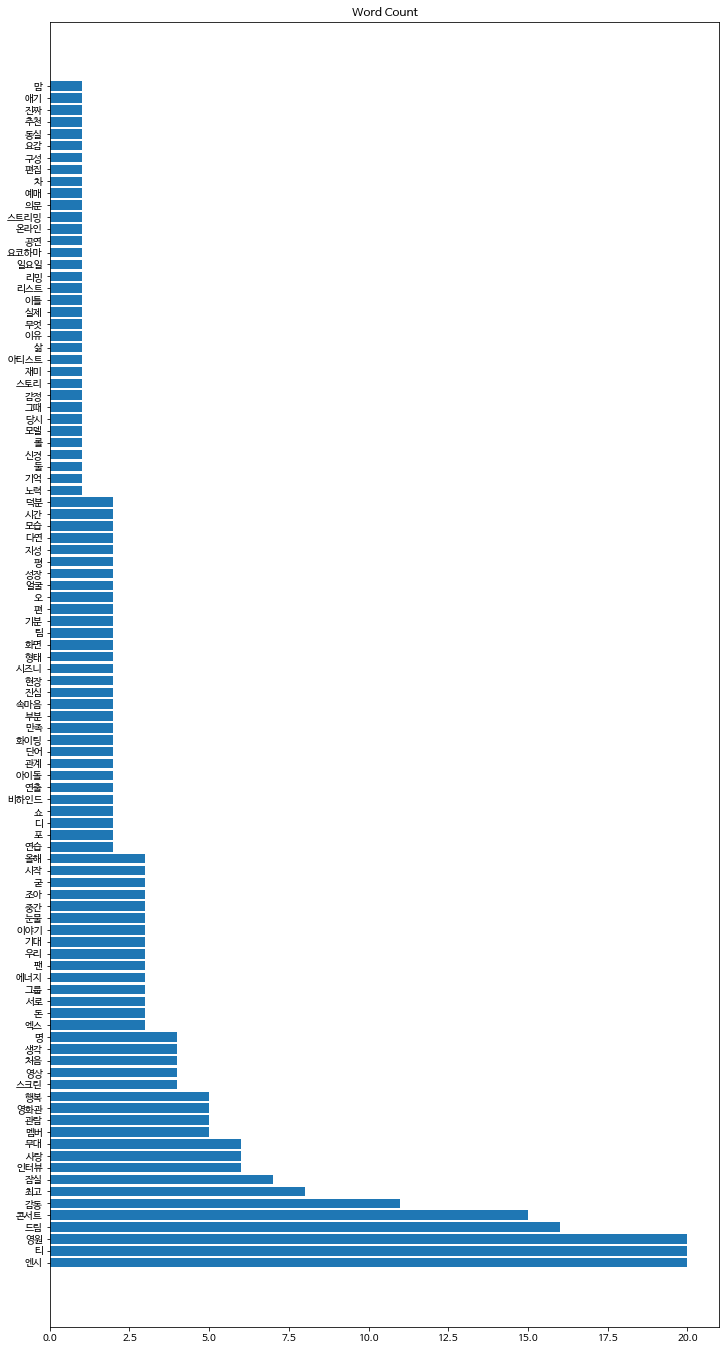

In [24]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

y_pos = np.arange(len(top_review_nouns))

plt.figure(figsize=(12, 24))
plt.barh(y_pos, top_review_nouns.values()) #수평 바차트
plt.title('Word Count')
plt.yticks(y_pos, top_review_nouns.keys())
plt.rc('font', family='NanumBarunGothic') 
plt.show();

## wordcloud 설치

In [25]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', font_path='./font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_review_nouns)

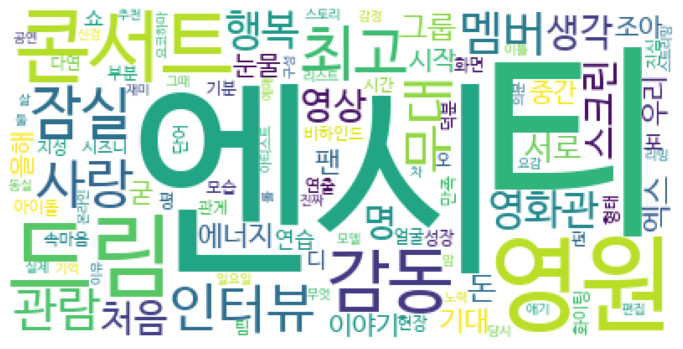

In [27]:
figure = plt.figure(figsize=(12, 12))
ax = figure.add_subplot(1, 1, 1)
ax.axis('off')
ax.imshow(wc)
plt.show()

# 환경 준비
1. 라이브러리 다운로드
2. 네이버 영화평과 긍부정 데이터를 다운로드합니다 (파일보기 +  새로고침 후 확인)

* 자체 데이터셋을 사용할 경우 내용과 카테고리가 각각 content와 label 열에 들어가는 파일(아래 예시 참조)로 dataset.xlsx로 저장 후 기존 파일을 덮어쓰기 하면 됩니다. 
* 엑셀파일의 label과 content의 순서는 상관없으나 label은 0부터 시작하는 숫자로 입력하면 좋습니다. 예를들어 카테고리가 4개면 label을 0, 1, 2, 3으로 표시해주세요.

```
label  content
1      영화가 재밌다.     
1      이 영화 추천해요.     
0      지루한 영화였습니다.
...  
```

In [ ]:
!pip3 install -q transformers
!git clone https://github.com/kiyoungkim1/ReadyToUseAI

from ReadyToUseAI.src.nlp import make_sample_dataset, bert_sequence_classification
make_sample_dataset.nsmc(mode='test', text_only=False)  # mode: which datasets? 'train' or 'test'

# [Training] 
* 첨부된 샘플의 경우 약 40min 소요 (Tesla T4 GPU)
* min_sentence_length보다 긴 문장만 사용합니다.
* MAX_LEN은 모델이 인식하는 token의 길이로, 전체길이가 약 MAX_LEN의 2배보다 긴 문장은 뒷부분이 삭제됩니다 (예를들어 MAX_LEN = 128이면, 대략 길이가 256이상인 문장은 뒷부분이 무시됨).
* batch_size는 한번에 몇개의 sample을 계산하는지를 나타내며, 제한된 메모리에서 MAX_LEN을 줄이면 batch_size를 키울 수 있고, MAX_LEN를 키우면 batch_size를 줄여야 합니다. 
* epochs는 데이터셋을 몇번 반복해서 학습할지 여부이며, dataset_split은 전체 데이터 중 몇 %를 검증용 데이터셋으로 사용할지 여부입니다.

In [ ]:
CLS = bert_sequence_classification.Classification(model_name='kykim/bert-kor-base', min_sentence_length=10, MAX_LEN=128, batch_size=32, use_bert_tokenizer=True)
CLS.dataset(data_path='dataset.xlsx')
CLS.load_model(mode='train')
CLS.train(epochs=3, dataset_split=0.1)

# [Inference]
* sentences에 원하는 문장을 아래 형식과 같이 넣으면 해당하는 카테고리를 반환합니다.
* saved_model_path는 학습된 모델이 저장된 '폴더명'입니다.

In [ ]:
#sentences = ['영화 재밌어요', '영화 재미없어요', '그냥 시간떼우기용', '완전 추천작']
saved_model_path='model/saved/3'

CLS = bert_sequence_classification.Classification(model_name='kykim/bert-kor-base', min_sentence_length=10, MAX_LEN=128, batch_size=64, use_bert_tokenizer=True)
CLS.load_model(mode='inference', saved_model_path=saved_model_path)
# reviews = 크롤링한 리뷰 데이터
review_down = pd.read_csv('./review.csv', encoding='utf-8')
review_frame = review_down['Review']
before = len(review_frame)
review_frame.dropna(inplace=True)
after = len(review_frame)
review_list = review_frame.values.tolist()
print('컴퓨터에 저장된 리뷰 다운받으면서 손실된 리뷰 개수 : ', before - after)
print('총 리뷰 개수 : ', after)
#logit = CLS.inference(sentences=reviews[1000:2000])

logit = CLS.inference(sentences=review_list)
#logit는 1과 0이 나타나는 리스트
#print(logit)  # 네이버 영화평의 경우 0은 부정 카테고리, 1은 긍정 카테고리로 설정되어 있음
rate = logit.count(1)/after * 100
print(f'긍정 예측 비율 : {rate:.2f}%')